In [78]:
#%matplotlib widget
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import sys
from pathlib import Path
import torch
import numpy as np
import tqdm

from ripser import ripser
from persim import plot_diagrams

# Plotting
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('../bioAI.mplstyle')

'''
CUSTOM PACKAGES
'''
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None

from Models import SorscherRNN
from Experiment import Experiment
from datahandling import Dataset, MESampler
from plotting_functions import *
from synthetic_grid_cells import *
from methods import *
from stats import *

In [3]:
#base_path = Path("/storA/GridCells/")
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name="gg-3ME", base_path=base_path)
experiment.setup()

module_indices = np.load(f"{experiment.paths['experiment']}/module_indices.npz")
print(module_indices.files)
module_indices = module_indices['C5_from_env_2']

ncells = len(module_indices)

# percentile is chosen manually to get 315 cells.
gs_masks = grid_score_masks(experiment, percentile=0.547, mode="intersection")
gs_idxs = np.where(gs_masks)[0]

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.
['C0_from_env_0', 'C1_from_env_1', 'C5_from_env_2']


In [82]:
experiment.params

{'Ng': 4096,
 'Np': 512,
 'sampler': 'MESampler',
 'weight_decay': 0.0001,
 'lr': 0.0001,
 'seq_len': 20,
 'batch_size': 200,
 'nsteps': 100,
 'nepochs': 3000,
 'save_freq': 10,
 'date': datetime.datetime(2022, 5, 31, 14, 12, 47, 761022)}

In [93]:
# detach experiment specifics
params = experiment.params
environments = experiment.environments
agents = experiment.agents
pc_ensembles = experiment.pc_ensembles
paths = experiment.paths

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{device=}")

# Initialise data loading
num_samples = params['nsteps'] * params['batch_size'] # * params['nepochs']
dataset = Dataset(agents = agents, pc_ensembles = pc_ensembles, num_samples = num_samples, seq_len=20)#, **params)
datasampler = eval(params['sampler'])(num_environments = len(environments), num_samples = num_samples, \
                                      num_epochs = params['nepochs'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], sampler = datasampler, num_workers=num_workers)

device=device(type='cuda')


In [5]:
def load_model(experiment):
    # load weights
    checkpoint_filenames = filenames(experiment.paths['checkpoints'])
    # load model latest (wrt. #epochs trained)
    print(f"Loading model at epoch = {checkpoint_filenames[-1]}", experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    checkpoint = torch.load(experiment.paths['checkpoints'] / checkpoint_filenames[-1])
    # instantiate trained model this time
    model = SorscherRNN(experiment.pc_ensembles, Ng=experiment.params['Ng'], Np=experiment.params['Np'])
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

model = load_model(experiment)

Loading model at epoch = 02999 /mnt/WD12TB-HDD/data/emergent-grid-cells/gg-3ME/checkpoints/02999


In [6]:
def smooth_ratemaps(model, idxs, **kwargs):
    model.prune_mask = list(set(module_indices) - set(idxs))
    ratemaps = compute_ratemaps(model=model.g, idxs=idxs, **kwargs).statistic
    from astropy.convolution import Gaussian2DKernel, convolve
    kernel = Gaussian2DKernel(x_stddev=1.0)
    smooth_ratemaps = convolve(ratemaps, kernel.array[None], boundary='extend')
    return smooth_ratemaps

In [47]:
panesize = set_size(width=345, mode='tall')
figsize = np.array((panesize[0]/3,panesize[1]*2/6))

plt.rcParams["figure.autolayout"] = False
plt.rcParams["figure.subplot.wspace"] = 0
plt.rcParams["figure.subplot.hspace"] = 0
plt.rcParams["figure.subplot.left"] = 0
plt.rcParams["figure.subplot.right"] = 1
plt.rcParams["figure.subplot.bottom"] = 0
plt.rcParams["figure.subplot.top"] = 1
plt.rcParams["figure.autolayout"] = True

In [8]:
pca_fits, umap_fits = [], []
res = np.array([64,64])
num_trajectories=3000

### Low dimensional projection of all torus cells

In [60]:
ratemaps = smooth_ratemaps(model,idxs=module_indices,dataset=dataset,num_trajectories=num_trajectories,res=res)
g = ratemaps.reshape(len(ratemaps),-1).T

pca_fit, umap_fit = PCA_UMAP(g)
pca_fits.append(pca_fit)
umap_fits.append(umap_fit)

100%|███████████████████████████████████████| 3000/3000 [02:56<00:00, 17.03it/s]


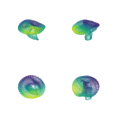

In [61]:
fig,axs = scatter3d(umap_fits[0], pca_fits[0][:,0],ncols=2,nrows=2,s=0.005,alpha=0.8,azim_elev_title=False, figsize=figsize)
fig.savefig(experiment.paths['experiment'] / f'plots/0-pruning')

(295,)

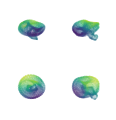

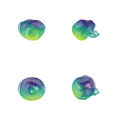

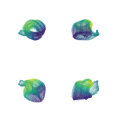

In [74]:
for n2exclude in [20, 50, 200]:
    idxs = np.random.choice(range(g.shape[-1]), size=g.shape[-1]-n2exclude, replace=False)
    pca_fit, umap_fit = PCA_UMAP(g[:,idxs])
    fig,axs = scatter3d(umap_fit, pca_fit[:,0],ncols=2,nrows=2,s=0.005,alpha=0.8,azim_elev_title=False, figsize=figsize)
    fig.savefig(experiment.paths['experiment'] / f'plots/0-pruning-#cells-{len(idxs)}')

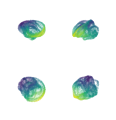

In [77]:
idxs = np.random.choice(range(g.shape[-1]), size=g.shape[-1]-300, replace=False)
pca_fit, umap_fit = PCA_UMAP(g[:,idxs])
fig,axs = scatter3d(umap_fit, pca_fit[:,0],ncols=2,nrows=2,s=0.005,alpha=0.8,azim_elev_title=False, figsize=figsize)
fig.savefig(experiment.paths['experiment'] / f'plots/0-pruning-#cells-{len(idxs)}')

### Low dimensional projection of torus after different levels of pruning

In [11]:
n2prune = 10
idxs2prune = np.random.choice(module_indices, size=ncells - n2prune, replace=False)
ratemaps = smooth_ratemaps(model,idxs=idxs2prune,dataset=dataset,num_trajectories=num_trajectories,res=res)
g = ratemaps.reshape(len(ratemaps),-1).T

pca_fit, umap_fit = PCA_UMAP(g)
pca_fits.append(pca_fit)
umap_fits.append(umap_fit)

100%|███████████████████████████████████████| 3000/3000 [02:42<00:00, 18.49it/s]


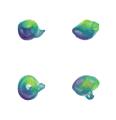

In [49]:
fig,axs = scatter3d(umap_fits[1], pca_fits[1][:,0],ncols=2,nrows=2,s=0.005,alpha=0.8,azim_elev_title=False, figsize=figsize)
fig.savefig(experiment.paths['experiment'] / f'plots/10-torus-pruning')

In [13]:
n2prune = 20
idxs2prune = np.random.choice(module_indices, size=ncells - n2prune, replace=False)
ratemaps = smooth_ratemaps(model,idxs=idxs2prune,dataset=dataset,num_trajectories=num_trajectories,res=res)
g = ratemaps.reshape(len(ratemaps),-1).T

pca_fit, umap_fit = PCA_UMAP(g)
pca_fits.append(pca_fit)
umap_fits.append(umap_fit)

100%|███████████████████████████████████████| 3000/3000 [02:38<00:00, 18.96it/s]


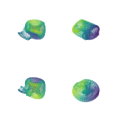

In [55]:
fig,axs = scatter3d(umap_fits[2], pca_fits[2][:,0],ncols=2,nrows=2,s=0.005,alpha=0.8,azim_elev_title=False, figsize=figsize)
fig.savefig(experiment.paths['experiment'] / f'plots/20-torus-pruning')

In [15]:
n2prune = 50
idxs2prune = np.random.choice(module_indices, size=ncells - n2prune, replace=False)
ratemaps = smooth_ratemaps(model,idxs=idxs2prune,dataset=dataset,num_trajectories=num_trajectories,res=res)
g = ratemaps.reshape(len(ratemaps),-1).T

pca_fit, umap_fit = PCA_UMAP(g)
pca_fits.append(pca_fit)
umap_fits.append(umap_fit)

100%|███████████████████████████████████████| 3000/3000 [02:43<00:00, 18.33it/s]


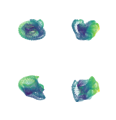

In [51]:
fig,axs = scatter3d(umap_fits[3], pca_fits[3][:,0],ncols=2,nrows=2,s=0.005,alpha=0.8,azim_elev_title=False, figsize=figsize)
fig.savefig(experiment.paths['experiment'] / f'plots/50-torus-pruning')

In [27]:
n2prune = 200
idxs2prune = np.random.choice(module_indices, size=ncells - n2prune, replace=False)
ratemaps = smooth_ratemaps(model,idxs=idxs2prune,dataset=dataset,num_trajectories=num_trajectories,res=res)
g = ratemaps.reshape(len(ratemaps),-1).T

pca_fit, umap_fit = PCA_UMAP(g)
pca_fits.append(pca_fit)
umap_fits.append(umap_fit)

100%|███████████████████████████████████████| 3000/3000 [02:45<00:00, 18.08it/s]


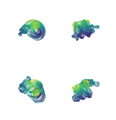

In [52]:
fig,axs = scatter3d(umap_fits[4], pca_fits[4][:,0],ncols=2,nrows=2,s=0.005,alpha=0.8,azim_elev_title=False, figsize=figsize)
fig.savefig(experiment.paths['experiment'] / f'plots/200-torus-pruning')

In [17]:
torch.sum(model.prune_mask[1]), np.prod(np.array(model.prune_mask[1].shape))

(tensor(16572416.), 16777216)

(array([22., 21., 15., 11., 19., 14.,  8.,  4.,  8.,  6.]),
 array([0.00067681, 0.01267306, 0.02466931, 0.03666556, 0.0486618 ,
        0.06065805, 0.0726543 , 0.08465055, 0.0966468 , 0.10864305,
        0.12063929]),
 <BarContainer object of 10 artists>)

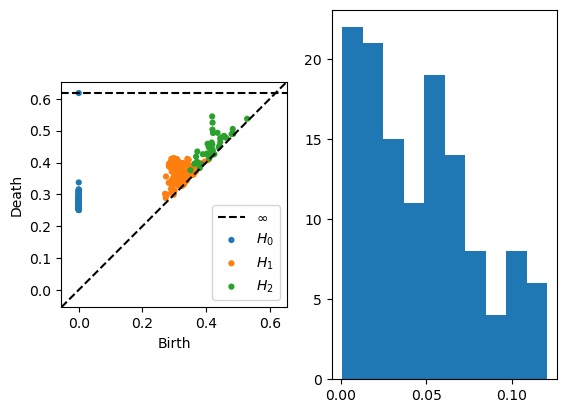

In [26]:
fig,axs = plt.subplots(ncols=2)
#dgms = ripser(g,maxdim=2,n_perm=150)['dgms']
dgms = ripser(pca_fits[0],maxdim=2,n_perm=150)['dgms']
plot_diagrams(dgms, show=False, ax=axs[0])
axs[1].hist(dgms[1][:,1] - dgms[1][:,0])